In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, Activation

In [3]:
# _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join('cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
ims = 256
IMG_SIZE = (ims, ims)

train_dataset = keras.utils.image_dataset_from_directory(train_dir, shuffle=True,batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [4]:
class_names = train_dataset.class_names
print(class_names)

['cats', 'dogs']


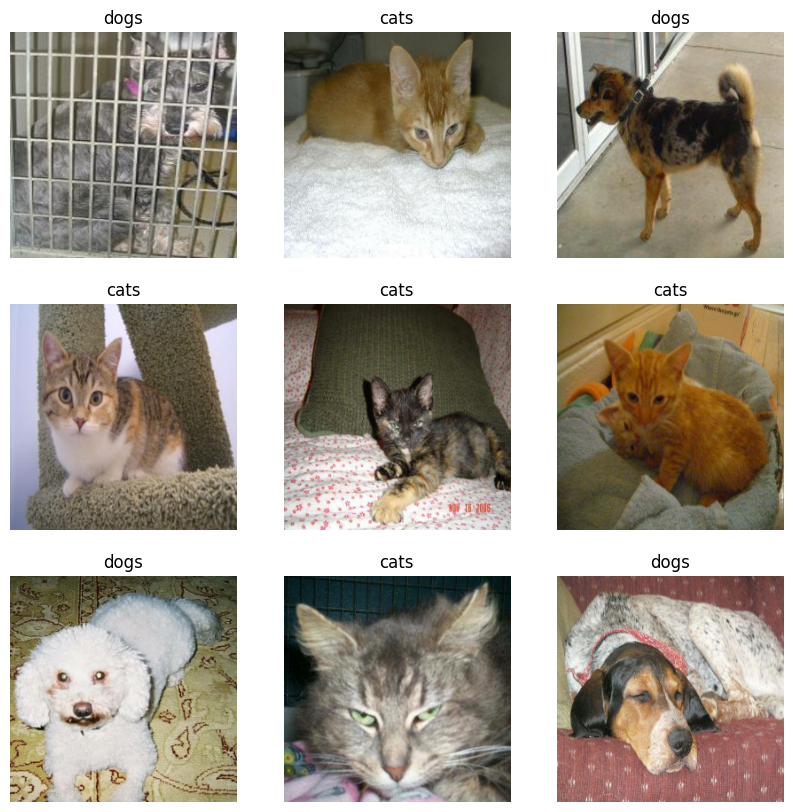

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [6]:
# (train_data # some tf.data.Dataset, likely in the form of tuples (x, y)
# .cache() # caches the dataset in memory (avoids having to reapply preprocessing transformations to the input)
# .shuffle(BUFFER_SIZE) # shuffle the samples to have always a random order of samples fed to the network
# .batch(BATCH_SIZE) # batch samples in chunks of size BATCH_SIZE (except the last one, that may be smaller)
# .repeat()) # repeat forever, meaning the dataset will keep producing batches and never terminate running out of data.

In [7]:
# Cardinality: The number of batches in a dataset.
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % val_batches)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 32
Number of test batches: 6


In [8]:
train_ds = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
data_augmentation = Sequential([
  layers.RandomFlip('horizontal'),
  layers.RandomRotation(0.2),
  
])

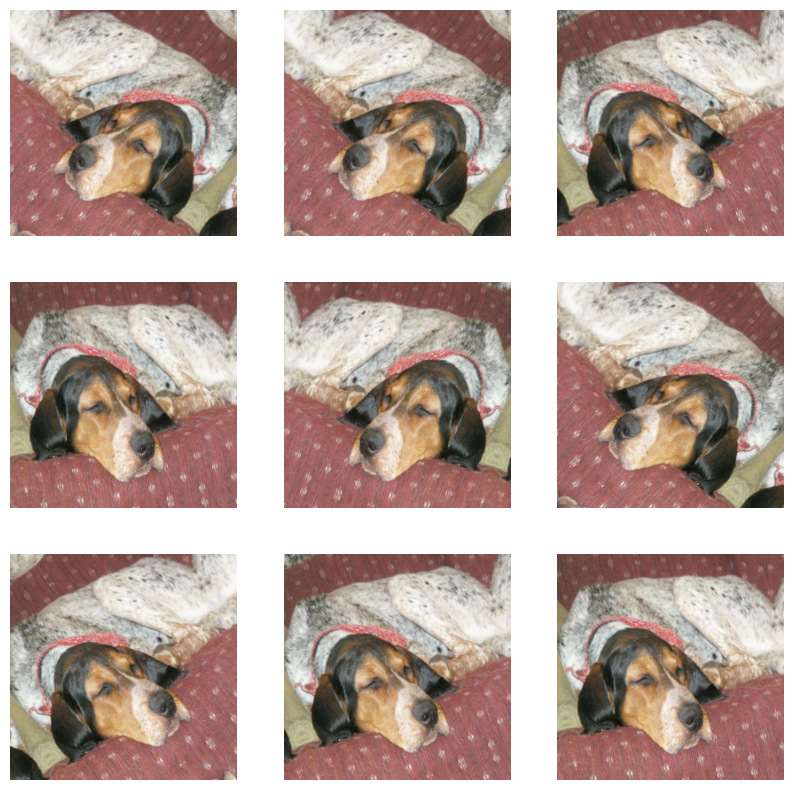

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
# remving the classification layer by include_top=False
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE, include_top=False,
                                               weights='imagenet')  # weights='imagenet' loads the weights pre-trained on ImageNet.

In [12]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 500

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  513


In [13]:
model = Sequential([
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),

    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(254, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax'),
])
model.build(input_shape=(None, ims, ims, 3))


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 8, 8, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 254)              

In [15]:
model.compile(optimizer=keras.optimizers.RMSprop(),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])


In [16]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[callback])

Epoch 1/100
63/63 [==============================] - 46s 476ms/step - loss: 0.0776 - accuracy: 0.9710 - val_loss: 0.0181 - val_accuracy: 0.9926
Epoch 2/100
63/63 [==============================] - 27s 429ms/step - loss: 0.0410 - accuracy: 0.9865 - val_loss: 0.0152 - val_accuracy: 0.9963
Epoch 3/100
63/63 [==============================] - 27s 429ms/step - loss: 0.0338 - accuracy: 0.9920 - val_loss: 0.0255 - val_accuracy: 0.9950
Epoch 4/100
63/63 [==============================] - 27s 429ms/step - loss: 0.0246 - accuracy: 0.9925 - val_loss: 0.0110 - val_accuracy: 0.9950
Epoch 5/100
63/63 [==============================] - 27s 430ms/step - loss: 0.0302 - accuracy: 0.9920 - val_loss: 0.0308 - val_accuracy: 0.9938
Epoch 6/100
63/63 [==============================] - 27s 430ms/step - loss: 0.0322 - accuracy: 0.9930 - val_loss: 0.0247 - val_accuracy: 0.9975
Epoch 7/100
63/63 [==============================] - 27s 434ms/step - loss: 0.0195 - accuracy: 0.9960 - val_loss: 0.0475 - val_accuracy:

In [17]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 1s 195ms/step - loss: 8.9840e-06 - accuracy: 1.0000
Test accuracy : 1.0


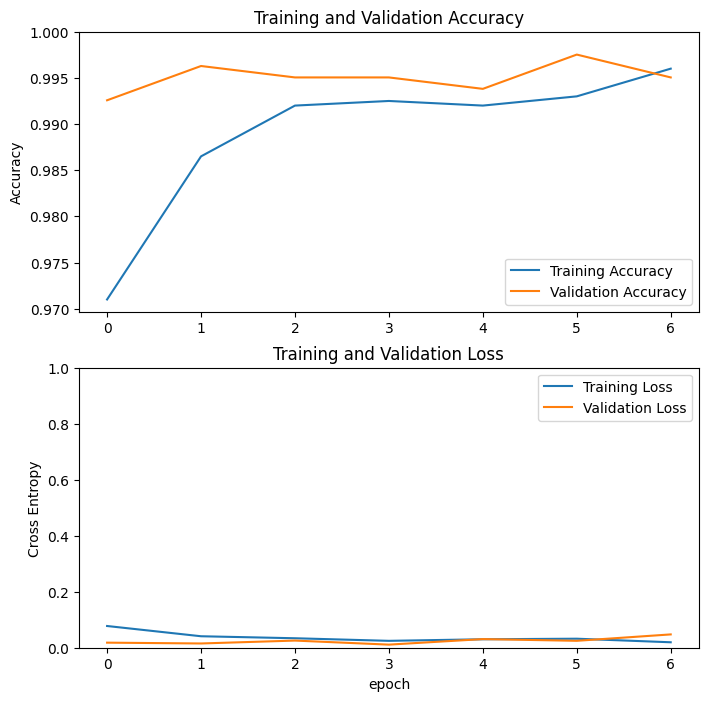

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
class_names = train_dataset.class_names
 

def predict(model, img):

    # Returns a tensor with a length 1 axis inserted at index axis.
    # (256, 256, 3) to (1, 256, 256, 3)
    img_array = tf.expand_dims(img,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


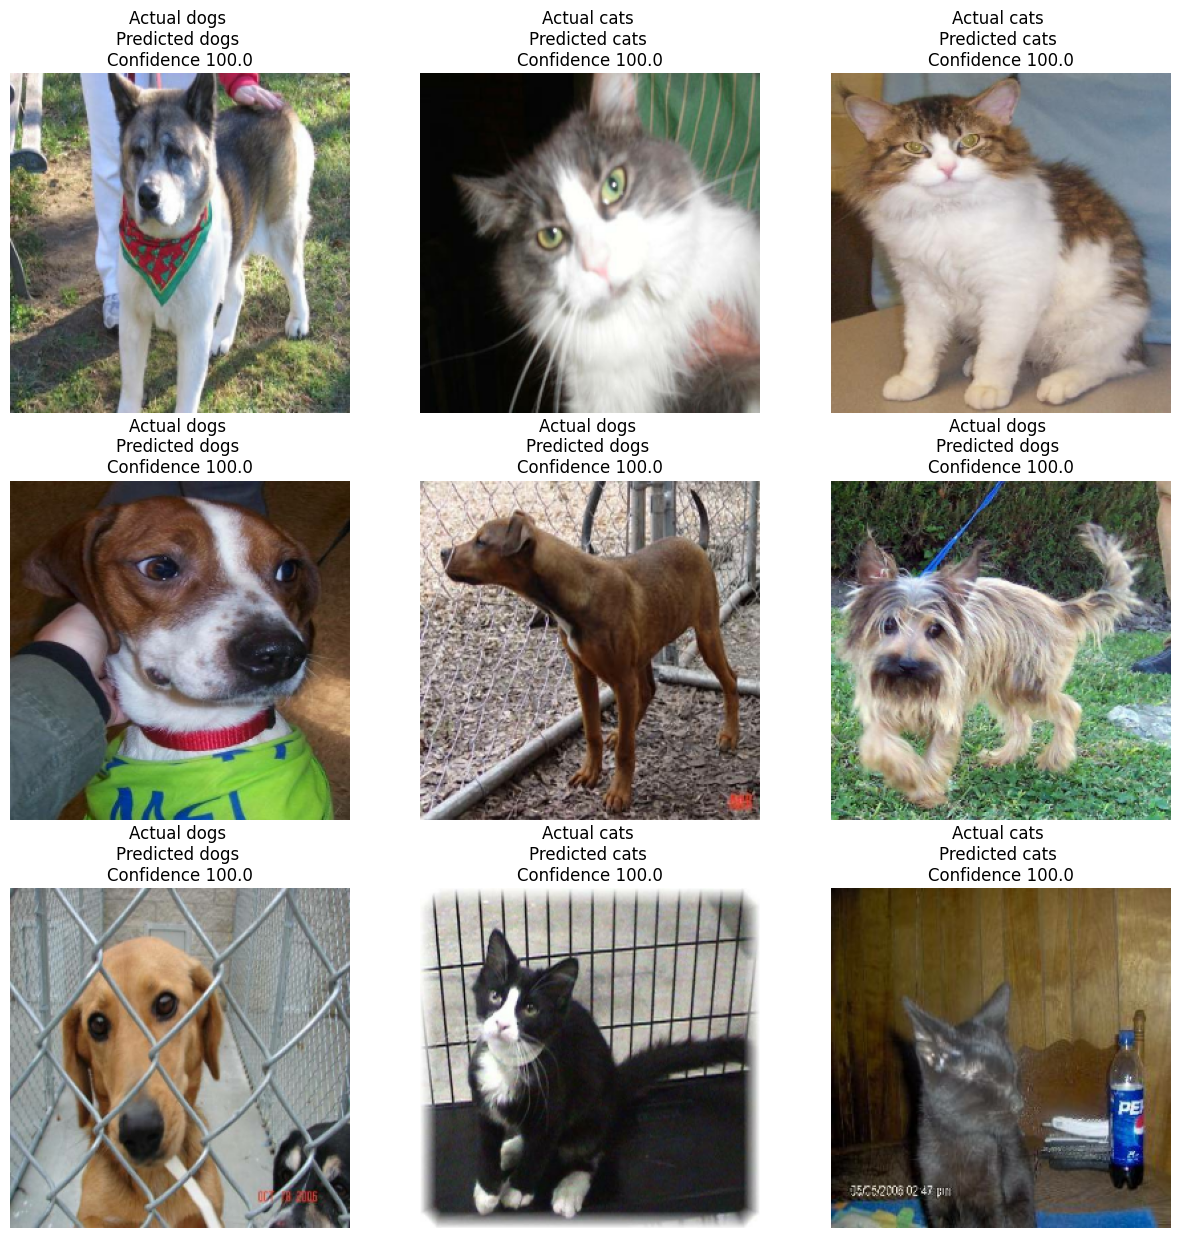

In [20]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f'Actual {actual_class} \nPredicted {predicted_class} \nConfidence {confidence}')
        plt.axis('off')

In [29]:
model_version = 'effnetv2m_1'
model_path = os.path.join(os.getcwd(), 'models')
model.save(f'{model_path}\{model_version}')

INFO:tensorflow:Assets written to: c:\Users\darklane\Desktop\ML_DL\Cat & Dog Clasifier\models\effnetv2m_1\assets


INFO:tensorflow:Assets written to: c:\Users\darklane\Desktop\ML_DL\Cat & Dog Clasifier\models\effnetv2m_1\assets


In [22]:
# model = tf.keras.models.load_model(f'/models/{model_version}')